In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.get_logger().setLevel("ERROR")

import ray
import numpy as np
import time

In [2]:
from trieste.objectives import scaled_branin

def objective(points, sleep=True):
    if points.shape[1] != 2:
        raise ValueError(f"Incorrect input shape, expected (*, 2), got {points.shape}")

    observations = []
    for point in points:
        observation = scaled_branin(point).numpy()
        if sleep:
            # insert some artificial delay
            # increases linearly with the absolute value of points
            # which means our evaluations will take different time
            delay = 3 * np.sum(point)
            time.sleep(delay)
        observations.append((point, observation))

    return observations

In [3]:
objective(np.array([[0.1, 0.5]]), sleep=False)

[(array([0.1, 0.5]), array([-0.42052567]))]

In [4]:
from trieste.space import Box
from trieste.data import Dataset
from trieste.objectives import SCALED_BRANIN_MINIMUM

search_space = Box([0, 0], [1, 1])
num_initial_points = 3
initial_query_points = search_space.sample(num_initial_points)
initial_observations = objective(initial_query_points, sleep=False)
initial_data = Dataset(
    query_points=initial_query_points,
    observations=tf.constant([x[1] for x in initial_observations], dtype=tf.float64),
)

import gpflow
from trieste.models.gpflow import GaussianProcessRegression


def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.RBF(variance=variance)
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)
    return GaussianProcessRegression(gpr)

In [5]:
@ray.remote
def ray_objective(points, sleep=True):
    return objective(points, sleep)

In [6]:
# Number of worker processes to run simultaneously
# Setting this to 1 will turn both setups into non-batch sequential optimization
num_workers = 3
# Number of observations to collect in the asynchronous scenario
num_observations = 30
# Set this flag to False to disable sleep delays in case you want the notebook to execute quickly
enable_sleep_delays = True

In [7]:
from trieste.acquisition.rule import AsynchronousOptimization
from trieste.ask_tell_optimization import AskTellOptimizer

model = build_model(initial_data)
async_rule = AsynchronousOptimization()  # type: ignore
async_bo = AskTellOptimizer(search_space, initial_data, model, async_rule)

In [8]:
ray.init(ignore_reinit_error=True)

2021-10-15 12:12:06,356	INFO services.py:1252 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.10.2.115',
 'raylet_ip_address': '10.10.2.115',
 'redis_address': '10.10.2.115:6379',
 'object_store_address': '/tmp/ray/session_2021-10-15_12-12-05_335632_28072/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-10-15_12-12-05_335632_28072/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-10-15_12-12-05_335632_28072',
 'metrics_export_port': 40040,
 'node_id': '56815c436533c10aaa0601f4b44dcb359fba0dea6af434e702b36829'}

In [9]:
points_observed = 0
workers = []

for _ in range(num_workers):
    point = async_bo.ask()
    worker = ray_objective.remote(point.numpy(), enable_sleep_delays)
    workers.append(worker)

while points_observed < num_observations:
    ready_workers, remaining_workers = ray.wait(workers, timeout=0)
    workers = remaining_workers
    
    if len(ready_workers) == 0:
        continue
    
    new_observations = [observation for worker in ready_workers for observation in ray.get(worker)]

    # new_data is a tuple of (point, observation value)
    # here we turn it into a Dataset and tell of it Trieste
    points_observed += len(new_observations)
    new_data = Dataset(
        query_points=tf.constant([x[0] for x in new_observations], dtype=tf.float64),
        observations=tf.constant([x[1] for x in new_observations], dtype=tf.float64),
    )
    async_bo.tell(new_data)

    for _ in ready_workers:
        point = async_bo.ask()
        worker = ray_objective.remote(point.numpy(), enable_sleep_delays)
        workers.append(worker)

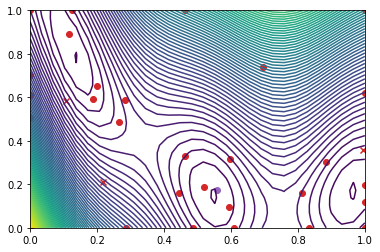

In [12]:
from util.plotting import plot_function_2d, plot_bo_points

dataset = async_bo.to_result().try_get_final_dataset()
arg_min_idx = tf.squeeze(tf.argmin(dataset.observations, axis=0))
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()
_, ax = plot_function_2d(
    scaled_branin, search_space.lower, search_space.upper, grid_density=30, contour=True
)

plot_bo_points(query_points, ax[0, 0], num_initial_points, arg_min_idx, c_pass="tab:red")

In [11]:
ray.shutdown()  # "Undo ray.init()". Terminate all the processes started in this notebook.